In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys

sys.path.append("../EDA")
DATA_PATH = "../instruction/movieReplicationSet.csv"
ALPHA = 0.005

import movie_data_formatter as mdf
import movie_rating_gender as mrgy
import general_functions as gf

df = pd.read_csv(DATA_PATH)
df = mdf.clean_data(df)
processed_data = mdf.convert_to_table(df)
processed_data = mrgy.reformat_gender_identity(processed_data)
df_onlychild = processed_data[processed_data['are_you_an_only_child'].isin([0, 1])].dropna(subset=['rating'])

# treat rating as a categorical variable
df_onlychild['rating'] = df_onlychild['rating']


# only keep spcific columns
df_onlychild = df_onlychild[['movie_name', 'year', 'rating', 'are_you_an_only_child']]

# theme for plots
sns.set_theme(style="whitegrid", font_scale=1.1)



# What proportion of movies show an “only child effect,” meaning ratings differ between only children and those with siblings?

In [4]:
# stats
variance_table = df_onlychild.groupby(['are_you_an_only_child'])['rating'].agg(['count','mean', 'median', 'var', 'std']).reset_index()
print(variance_table)

# treat as ordinal variable
df_onlychild['rating'] = pd.Categorical(df_onlychild['rating'], ordered=True)


   are_you_an_only_child  count      mean  median       var       std
0                    0.0  91220  2.857871     3.0  1.071655  1.035208
1                    1.0  18942  2.703701     3.0  1.304644  1.142210


In [5]:
# ---------- Prep ----------
hue_order = [0, 1]
hue_labels = ['No', 'Yes']
hue_palette = {0: '#4d4d4d', 1: '#bdbdbd'}  # dark vs light grey

ratings_sorted = sorted(merged['rating'].unique(), key=float)
greys = plt.cm.Greys(np.linspace(0.3, 0.85, len(ratings_sorted)))
rating_to_grey = {float(r): greys[i] for i, r in enumerate(ratings_sorted)}

# ---------- Three side-by-side subplots ----------
fig, ax = plt.subplots(3, 1, figsize=(14, 10))

# ---------- (1) side-by-side countplots ----------
sns.countplot(
    data=df_onlychild, x='rating', hue='are_you_an_only_child',
    hue_order=hue_order, palette=hue_palette,
    order=ratings_sorted,
    ax=ax[0]
)
ax[0].set_xlabel('Rating')
ax[0].set_ylabel('Count')
ax[0].set_title('Count of Ratings by Only Child Status')
ax[0].legend(title='Only Child', labels=hue_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

# ---------- (2) CDFs per rating (greyscale) ----------
for r in ratings_sorted:
    subset = merged[merged['rating'] == r]
    sorted_diff = np.sort(subset['difference'])
    if len(sorted_diff) == 0:
        continue
    cdf = np.arange(1, len(sorted_diff) + 1) / len(sorted_diff)
    ax[1].plot(
        sorted_diff, cdf,
        marker='.', linestyle='none',
        label=f'Rating {r}',
        color=rating_to_grey[float(r)]
    )

ax[1].set_xlabel('Difference in Proportion')
ax[1].set_ylabel('CDF')
ax[1].set_title('CDF of Differences')
ax[1].legend(title='Ratings', bbox_to_anchor=(1.05, 1), loc='upper left')

# ---------- (3) Overall PMF (single grey) ----------
sns.histplot(
    merged, x="difference", bins=30, stat="probability", kde=False,
    color='#4d4d4d', edgecolor='#222222', ax=ax[2]
)
ax[2].set_xlabel('Difference in Proportion')
ax[2].set_ylabel('Probability')
ax[2].set_title('Overall PMF of Differences')

plt.tight_layout()

# save to pdf
plt.savefig('../figures/only_child_rating_differences_plots.pdf')

NameError: name 'merged' is not defined

In [ ]:
def total_variation_distance(p, q):
    print("p:", p)
    print("q:", q)
   
    # calculate total variation distance (0, 0.5, 1, 1.5, 2, ..., 4)
    bins = np.arange(0, 4.5, 0.5)
    p_hist, _ = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bins, density=True)
    p = p_hist / p_hist.sum()
    q = q_hist / q_hist.sum()
    return 0.5 * np.sum(np.abs(p - q))


df_gender_movie = df_onlychild.groupby(['movie_name', 'year'])
df_gender_movie.size()

n_movies = len(df_gender_movie)

results = pd.DataFrame(columns=['prop', 'mw_p_value', 'mw_u_stat'])

for name, group in df_gender_movie:
    movie_name = name[0] + " (" + str(name[1]) + ")"
    # drop NA ratings
    ratings = group['rating'].dropna()

    # Split ratings by only child status
    only_child_ratings = ratings[group['are_you_an_only_child'] == 1].astype(float)
    not_only_child_ratings = ratings[group['are_you_an_only_child'] == 0].astype(float)

    if len(only_child_ratings) > 0 and len(not_only_child_ratings) > 0:

        # check if ratings have na values
        if only_child_ratings.isna().sum() > 0 or not_only_child_ratings.isna().sum() > 0:
            print(f"NA values found in ratings for movie: {movie_name}")
            continue
        
        # Mann-Whitney U Test
        u_stat, p_value_mw = stats.mannwhitneyu(only_child_ratings, not_only_child_ratings, alternative='two-sided')
        
        # KS test
        ks_stat, p_value_ks = stats.ks_2samp(only_child_ratings, not_only_child_ratings)

        only_child = only_child_ratings.value_counts(normalize=True)
        not_only_child = not_only_child_ratings.value_counts(normalize=True)
        results.loc[movie_name] = [total_variation_distance(only_child, not_only_child), p_value_mw, u_stat]

p: rating
4.0    0.338028
3.5    0.211268
3.0    0.169014
2.5    0.098592
1.5    0.070423
2.0    0.070423
0.5    0.028169
1.0    0.014085
Name: proportion, dtype: float64
q: rating
4.0    0.373391
3.5    0.242489
3.0    0.178112
2.5    0.085837
2.0    0.055794
1.5    0.021459
1.0    0.019313
0.5    0.012876
0.0    0.010730
Name: proportion, dtype: float64
p: rating
2.5    0.307692
2.0    0.192308
3.0    0.153846
3.5    0.115385
0.5    0.076923
0.0    0.076923
1.0    0.038462
4.0    0.038462
Name: proportion, dtype: float64
q: rating
2.0    0.194631
3.0    0.167785
2.5    0.140940
4.0    0.127517
1.0    0.114094
1.5    0.093960
3.5    0.067114
0.0    0.046980
0.5    0.046980
Name: proportion, dtype: float64
p: rating
4.0    0.285714
2.5    0.250000
3.5    0.142857
2.0    0.107143
3.0    0.071429
0.0    0.071429
1.0    0.035714
1.5    0.035714
Name: proportion, dtype: float64
q: rating
2.5    0.188119
4.0    0.168317
3.5    0.168317
3.0    0.148515
2.0    0.128713
0.5    0.069307
1.5    

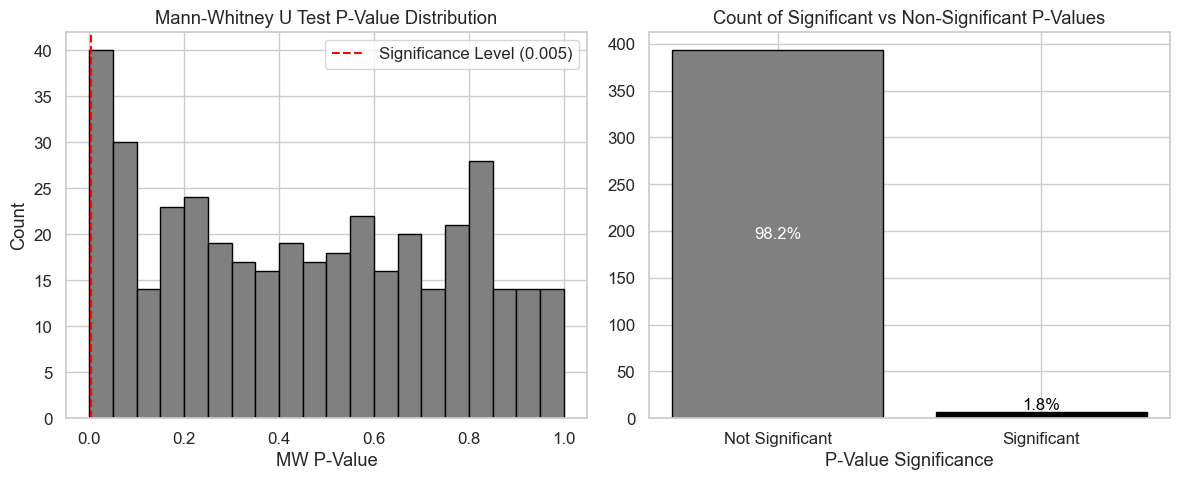

In [ ]:
# one figure 
fig, ax = plt.subplots(1,2, figsize=(12, 5), dpi=100)

# distbution of p-values
results['mw_p_value'].hist(bins=20, ax=ax[0], color='gray', edgecolor='black')
ax[0].axvline(x=ALPHA, color='red', linestyle='--', label='Significance Level ({})'.format(ALPHA))
ax[0].set_title('Mann-Whitney U Test P-Value Distribution')
ax[0].set_xlabel('MW P-Value')
ax[0].set_ylabel('Count')
ax[0].legend()

# count of significant p-values and non-significant p-values
sig = results['mw_p_value'] < ALPHA
nonsig = results['mw_p_value'] >= ALPHA
ax[1].bar(['Not Significant', 'Significant'], [nonsig.sum(), sig.sum()], color=['gray', 'black'], edgecolor='black')
ax[1].set_title('Count of Significant vs Non-Significant P-Values')
ax[1].set_xlabel('P-Value Significance')

# annotations of the % 
total = len(results)
ax[1].text(0, nonsig.sum()/2, f"{(nonsig.sum()/total)*100:.1f}%", ha='center', va='center', color='white', fontsize=12)
ax[1].text(1, sig.sum()/2 + 10, f"{(sig.sum()/total)*100:.1f}%", ha='center', va='center', color='black', fontsize=12)

plt.tight_layout()
plt.savefig('../figures/only_child_mw_pvalue_distribution.pdf', bbox_inches='tight')

In [ ]:
# proportions of movies with significant differences
significant_mw = (results['mw_p_value'] < ALPHA).sum()

# avg_mw_u_stat = results['mw_u_stat'][results['mw_p_value'] < ALPHA].mean()
# median_mw_u_stat = results['mw_u_stat'][results['mw_p_value'] < ALPHA].median()

print(f"Number of movies with significant differences (Mann-Whitney U test): {significant_mw} out of {n_movies} = {significant_mw / n_movies:.2%}")


Number of movies with significant differences (Mann-Whitney U test): 7 out of 400 = 1.75%
